In [2]:
 # Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random
# from IPython.core.debugger import set_trace
from collections import deque
import sqlite3
import tensorflow as tf
import os

In [3]:

# 데이터베이스 연결
conn = sqlite3.connect('symbols.db')
cursor = conn.cursor()

# 외래키 제약 조건 비활성화 (트랜잭션 성능 향상을 위해)
cursor.execute("PRAGMA foreign_keys=OFF")

# 'symbols' 테이블에서 symbol 가져오기
cursor.execute('SELECT symbol FROM symbols')
symbols = cursor.fetchall()

# 실제 데이터베이스에 존재하는 테이블 목록 가져오기
cursor.execute("SELECT name FROM sqlite_master WHERE type='table'")
all_tables = [table[0] for table in cursor.fetchall()]

# 인덱스 생성 (timestamp 기준으로 빠른 검색을 위해)
for symbol in symbols:
    symbol_name = symbol[0]

    if symbol_name in all_tables:
        cursor.execute(f"CREATE INDEX IF NOT EXISTS idx_timestamp_{symbol_name} ON '{symbol_name}'(timestamp)")
        cursor.execute(f"CREATE INDEX IF NOT EXISTS idx_timestamp_ex_rate ON 'ex_rate'(timestamp)")
        cursor.execute(f"CREATE INDEX IF NOT EXISTS idx_timestamp_ex_usdt_rate ON 'ex_usdt_rate'(timestamp)")

# 트랜잭션 처리 시작
try:
    for symbol in symbols:
        symbol_name = symbol[0]

        if symbol_name in all_tables:
            cursor.execute(f"PRAGMA table_info('{symbol_name}')")
            columns = [column[1] for column in cursor.fetchall()]

            # 'bybit_close_krw_usd' 열이 없으면 추가
            if 'bybit_close_krw_usd' not in columns:
                cursor.execute(f'ALTER TABLE "{symbol_name}" ADD COLUMN bybit_close_krw_usd REAL')

            # 'bybit_close_krw_usdt' 열이 없으면 추가
            if 'bybit_close_krw_usdt' not in columns:
                cursor.execute(f'ALTER TABLE "{symbol_name}" ADD COLUMN bybit_close_krw_usdt REAL')

            # 'kimchi_premium_usd' 열이 없으면 추가
            if 'kimchi_premium_usd' not in columns:
                cursor.execute(f'ALTER TABLE "{symbol_name}" ADD COLUMN kimchi_premium_usd REAL')

            # 'kimchi_premium_usdt' 열이 없으면 추가
            if 'kimchi_premium_usdt' not in columns:
                cursor.execute(f'ALTER TABLE "{symbol_name}" ADD COLUMN kimchi_premium_usdt REAL')

            # 'symbol'와 'ex_rate' 테이블을 timestamp 기준으로 조인하여 bybit_close_krw_usd 값 업데이트
            cursor.execute(f'''
                UPDATE "{symbol_name}"
                SET bybit_close_krw_usd = (
                    SELECT bybit_close * krw_usd
                    FROM "ex_rate"
                    WHERE "{symbol_name}".timestamp = "ex_rate".timestamp
                    AND "ex_rate".timestamp IS NOT NULL
                    AND bybit_close IS NOT NULL
                )
            ''')

            # 'symbol'와 'ex_usdt_rate' 테이블을 timestamp 기준으로 조인하여 bybit_close_krw_usdt 값 업데이트
            cursor.execute(f'''
                UPDATE "{symbol_name}"
                SET bybit_close_krw_usdt = (
                    SELECT bybit_close * KRW_USDT
                    FROM "ex_usdt_rate"
                    WHERE "ex_usdt_rate".timestamp = "{symbol_name}".timestamp
                )
            ''')

            # 'symbol'와 'ex_rate' 테이블을 timestamp 기준으로 조인하여 김프 계산 (USD 기준)
            cursor.execute(f'''
                UPDATE "{symbol_name}"
                SET kimchi_premium_usd = (
                    SELECT (upbit_close / bybit_close_krw_usd - 1) * 100
                    FROM "ex_rate"
                    WHERE "{symbol_name}".timestamp = "ex_rate".timestamp
                    AND "ex_rate".timestamp IS NOT NULL
                )
            ''')

            # 'symbol'와 'ex_usdt_rate' 테이블을 timestamp 기준으로 조인하여 김프 계산 (USDT 기준)
            cursor.execute(f'''
                UPDATE "{symbol_name}"
                SET kimchi_premium_usdt = (
                    SELECT (upbit_close / bybit_close_krw_usdt - 1) * 100
                    FROM "ex_usdt_rate"
                    WHERE "ex_usdt_rate".timestamp = "{symbol_name}".timestamp
                )
            ''')

    # 변경사항 커밋
    conn.commit()

except Exception as e:
    # 에러 발생 시 롤백
    conn.rollback()
    print(f"Error occurred: {e}")

finally:
    # 외래키 제약 조건 다시 활성화
    cursor.execute("PRAGMA foreign_keys=ON")
    conn.close()


In [4]:

# 데이터베이스 연결
conn = sqlite3.connect('symbols.db')
cursor = conn.cursor()

# AAVE 테이블에서 데이터 가져오기 (timestamp, upbit_close, bybit_close_krw_usdt, kimchi_premium_usdt)
cursor.execute("SELECT * FROM BTC")
data = cursor.fetchall()

# AAVE 테이블의 열 이름 가져오기
cursor.execute("PRAGMA table_info(BTC);")
columns = cursor.fetchall()

# 열 이름 추출
column_names = [column[1] for column in columns]

# 데이터셋을 pandas DataFrame으로 변환
dataset = pd.DataFrame(data, columns=column_names)

# 결측값 제거
dataset = dataset.dropna()

# 데이터 출력 (예시: 상위 3개 행 출력)
print(dataset.head(3))

# 연결 종료
conn.close()


                      timestamp  upbit_close  bybit_close  \
1696  2024-12-27 10:00:00+00:00  144940000.0      96542.4   
1697  2024-12-27 11:00:00+00:00  145284000.0      96900.0   
1698  2024-12-27 12:00:00+00:00  144733000.0      96649.1   

      bybit_close_krw_usd  bybit_close_krw_usdt  kimchi_premium_usd  \
1696         1.422311e+08           145006684.8            1.904583   
1697         1.426707e+08           145350000.0            1.831692   
1698         1.423110e+08           144877000.9            1.701933   

      kimchi_premium_usdt  
1696            -0.045987  
1697            -0.045408  
1698            -0.099395  


X_train_KP 상위 6개 값: [1.9045830168097133, 1.8316915346330065, 1.7019331331584286, 1.8997125196392517, 2.1277850981278545, 2.642972532403909]


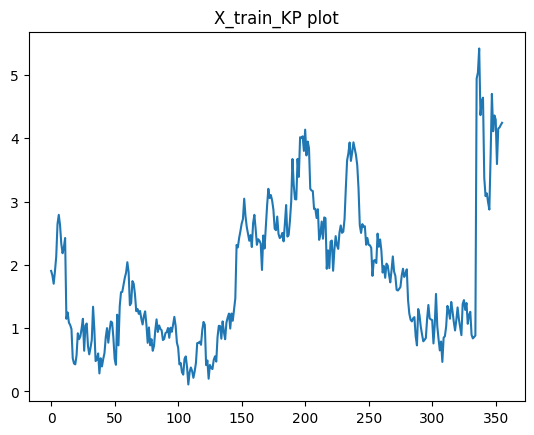

data_train 상위 5개 값:
                      timestamp  upbit_close  bybit_close  \
1696  2024-12-27 10:00:00+00:00  144940000.0      96542.4   
1697  2024-12-27 11:00:00+00:00  145284000.0      96900.0   
1698  2024-12-27 12:00:00+00:00  144733000.0      96649.1   
1699  2024-12-27 13:00:00+00:00  144632000.0      96388.3   
1700  2024-12-27 14:00:00+00:00  143797000.0      95639.9   

      bybit_close_krw_usd  bybit_close_krw_usdt  kimchi_premium_usd  \
1696         1.422311e+08           145006684.8            1.904583   
1697         1.426707e+08           145350000.0            1.831692   
1698         1.423110e+08           144877000.9            1.701933   
1699         1.419356e+08           144678838.3            1.899713   
1700         1.408011e+08           143842409.6            2.127785   

      kimchi_premium_usdt  
1696            -0.045987  
1697            -0.045408  
1698            -0.099395  
1699            -0.032374  
1700            -0.031569  
data_test 상위 5개 값:

In [5]:
selected_data = dataset.iloc[:, [5]]
data = dataset

# 데이터를 리스트로 변환
X = selected_data.values.flatten()  # 2D 배열을 1D로 변환
X = [float(x) for x in X]  # float로 변환

validation_size = 0.2

# In case the data is not dependent on the time series, then train and test split should be done based on sequential sample
# This can be done by selecting an arbitrary split point in the ordered list of observations and creating two new datasets.
train_size = int(len(X) * (1 - validation_size))
X_train_KP, X_test_KP = X[0:train_size], X[train_size:len(X)]

# `data`도 동일한 인덱스에 맞게 나누기
X_train_price = data.iloc[0:train_size]
X_test_price = data.iloc[train_size:]

# X_train의 상위 3개 값 출력
print("X_train_KP 상위 6개 값:", X_train_KP[:6])

# X_train 플로팅
plt.plot(X_train_KP)
plt.title("X_train_KP plot")
plt.show()

# 추가로, 나누어진 `data_train`, `data_test`도 출력하여 확인
print("data_train 상위 5개 값:")
print(X_train_price.head())

print("data_test 상위 5개 값:")
print(X_test_price.head())


In [6]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.models import load_model
# from tensorflow.keras.layers import Dense
# from tensorflow.keras.optimizers import Adam

class Agent:
    def __init__(self, state_size, is_eval=False, model_name=""):
        #State size depends and is equal to the the window size, n previous days
        self.state_size = state_size # normalized previous days,
        self.action_size = 3 # sit, buy, sell
        self.memory = deque(maxlen=1000)
        self.inventory = []
        self.model_name = model_name
        self.is_eval = is_eval

        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        #self.epsilon_decay = 0.9

        #self.model = self._model()

        self.model = tf.keras.models.load_model(model_name) if is_eval else self._model()

    #Deep Q Learning model- returns the q-value when given state as input
    def _model(self):
        model = tf.keras.models.Sequential()
        #Input Layer
        model.add(tf.keras.layers.Dense(units=64, input_dim=self.state_size, activation="relu"))
        #Hidden Layers
        model.add(tf.keras.layers.Dense(units=32, activation="relu"))
        model.add(tf.keras.layers.Dense(units=8, activation="relu"))
        #Output Layer
        model.add(tf.keras.layers.Dense(self.action_size, activation="linear"))
        model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
        return model

    #Return the action on the value function
    #With probability (1-$\epsilon$) choose the action which has the highest Q-value.
    #With probability ($\epsilon$) choose any action at random.
    #Intitially high epsilon-more random, later less
    #The trained agents were evaluated by different initial random condition
    #and an e-greedy policy with epsilon 0.05. This procedure is adopted to minimize the possibility of overfitting during evaluation.

    def act(self, state):
        #If it is test and self.epsilon is still very high, once the epsilon become low, there are no random
        #actions suggested.
        if not self.is_eval and random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        options = self.model.predict(state)
        #set_trace()
        #action is based on the action that has the highest value from the q-value function.
        return np.argmax(options[0])

    def expReplay(self, batch_size):
        mini_batch = []
        l = len(self.memory)
        for i in range(l - batch_size + 1, l):
            mini_batch.append(self.memory[i])

        # the memory during the training phase.
        for state, action, reward, next_state, done in mini_batch:
            target = reward # reward or Q at time t
            #update the Q table based on Q table equation
            #set_trace()
            if not done:
                #set_trace()
                #max of the array of the predicted.
                target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])

            # Q-value of the state currently from the table
            target_f = self.model.predict(state)
            # Update the output Q table for the given action in the table
            target_f[0][action] = target
            #train and fit the model where state is X and target_f is Y, where the target is updated.
            self.model.fit(state, target_f, epochs=1, verbose=0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [7]:
# prints formatted price
def formatPrice(n):
    return ("-$" if n < 0 else "$") + "{0:.2f}".format(abs(n))

# # returns the vector containing stock data from a fixed file
# def getStockData(key):
#     vec = []
#     lines = open("data/" + key + ".csv", "r").read().splitlines()

#     for line in lines[1:]:
#         vec.append(float(line.split(",")[4])) #Only Close column

#     return vec

# returns the sigmoid
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

# returns an an n-day state representation ending at time t

def getState(data, t, n):
    d = t - n + 1
    block = data[d:t + 1] if d >= 0 else -d * [data[0]] + data[0:t + 1] # pad with t0
    #block is which is the for [1283.27002, 1283.27002]
    res = []
    for i in range(n - 1):
        res.append(sigmoid(block[i + 1] - block[i]))
    return np.array([res])

# Plots the behavior of the output
def plot_behavior(data_input, states_buy, states_sell, profit):
    fig = plt.figure(figsize = (15,5))
    plt.plot(data_input, color='r', lw=2.)
    plt.plot(data_input, '^', markersize=10, color='m', label = 'Buying signal', markevery = states_buy)
    plt.plot(data_input, 'v', markersize=10, color='k', label = 'Selling signal', markevery = states_sell)
    plt.title('Total gains: %f'%(profit))
    plt.legend()
    #plt.savefig('output/'+name+'.png')
    plt.show()

In [ ]:
tf.keras.utils.disable_interactive_logging()
window_size = 1
agent = Agent(window_size)
#In this step we feed the closing value of the stock price
data = X_train_KP
l = len(data) - 1
#
batch_size = 32
#An episode represents a complete pass over the data.
episode_count = 10

for e in range(episode_count + 1):
    print("Running episode " + str(e) + "/" + str(episode_count))
    state = getState(data, 0, window_size + 1)
    #set_trace()
    total_profit = 0
    agent.inventory = []
    states_sell = []
    states_buy = []
    for t in range(l):
        action = agent.act(state)
        # sit
        next_state = getState(data, t + 1, window_size + 1)
        reward = 0

        if action == 1: # buy
            agent.inventory.append(data[t])
            states_buy.append(t)
            print("Buy: " + formatPrice(data[t]))

        elif action == 2 and len(agent.inventory) > 0: # sell
            bought_price = agent.inventory.pop(0)
            reward = max(data[t] - bought_price, 0)
            total_profit += data[t] - bought_price
            states_sell.append(t)
            print("Sell: " + formatPrice(data[t]) + " | Profit: " + formatPrice(data[t] - bought_price))

        done = True if t == l - 1 else False
        #appends the details of the state action etc in the memory, which is used further by the exeReply function
        agent.memory.append((state, action, reward, next_state, done))
        state = next_state

        if done:
            print("--------------------------------")
            print("Total Profit: " + formatPrice(total_profit))
            print("--------------------------------")
            #set_trace()
            #pd.DataFrame(np.array(agent.memory)).to_csv("Agent"+str(e)+".csv")
            #Chart to show how the model performs with the stock goin up and down for each
            plot_behavior(data,states_buy, states_sell, total_profit)
        if len(agent.memory) > batch_size:
            agent.expReplay(batch_size)


    if e % 2 == 0:
      working_dir = os.getcwd()
      agent.model.save(working_dir + "/model_ep" + str(e) + ".keras")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Running episode 0/10
Buy: $1.90
Buy: $1.70
Buy: $1.90
Buy: $2.13
Buy: $2.64
Sell: $2.63 | Profit: $0.73
Buy: $2.18
Sell: $2.27 | Profit: $0.57
Sell: $1.15 | Profit: -$0.75
Buy: $1.25
Buy: $1.09
Buy: $0.99
Buy: $0.44
Sell: $0.43 | Profit: -$1.70
Buy: $0.92
Buy: $0.83
Sell: $0.87 | Profit: -$1.77
Sell: $1.00 | Profit: -$1.19
Sell: $1.15 | Profit: -$0.10
Sell: $1.04 | Profit: -$0.05
Buy: $1.07
Buy: $0.59
Buy: $0.99
Buy: $0.48
Sell: $0.50 | Profit: -$0.48
Sell: $0.60 | Profit: $0.16
Sell: $0.52 | Profit: -$0.39
Sell: $0.39 | Profit: -$0.43
Buy: $0.61
Buy: $0.86
Buy: $1.00
Sell: $0.77 | Profit: -$0.30
Sell: $0.96 | Profit: $0.38
Sell: $1.10 | Profit: $0.12
Buy: $0.85
Buy: $0.51
Sell: $0.42 | Profit: -$0.06
Sell: $1.21 | Profit: $0.61
Buy: $0.73
Sell: $1.35 | Profit: $0.49
Buy: $1.57
Buy: $1.57
Buy: $1.68
Sell: $1.80 | Profit: $0.80
Buy: $1.88
Buy: $1.40
Buy: $1.74
Sell: $1.70 | Profit: $0.85
Buy: $1.53
Sell: $1.27 | Profit: $0.75
Sell: $1.30 | Profit: $0.58
Sell: $1.23 | Profit: -$0.34
Sell

In [ ]:
print(agent.model.summary())

In [ ]:
#agent is already defined in the training set above.
test_data = X_test_KP
l_test = len(test_data) - 1
state = getState(test_data, 0, window_size + 1)
total_profit = 0
is_eval = True
done = False
states_sell_test = []
states_buy_test = []
#Get the trained model
model_name = working_dir+"/model_ep"+str(episode_count)+".keras"
agent = Agent(window_size, is_eval, model_name)
state = getState(data, 0, window_size + 1)
total_profit = 0
agent.inventory = []

In [ ]:
for t in range(l_test):
    action = agent.act(state)
    #print(action)
    #set_trace()
    next_state = getState(test_data, t + 1, window_size + 1)
    reward = 0

    if action == 1:
        agent.inventory.append(test_data[t])
        states_buy_test.append(t)
        print("Buy: " + formatPrice(test_data[t]))

    elif action == 2 and len(agent.inventory) > 0:
        bought_price = agent.inventory.pop(0)
        reward = max(test_data[t] - bought_price, 0)
        #reward = test_data[t] - bought_price
        total_profit += test_data[t] - bought_price
        states_sell_test.append(t)
        print("Sell: " + formatPrice(test_data[t]) + " | profit: " + formatPrice(test_data[t] - bought_price))

    if t == l_test - 1:
        done = True
    agent.memory.append((state, action, reward, next_state, done))
    state = next_state

    if done:
        print("------------------------------------------")
        print("Total Profit: " + formatPrice(total_profit))
        print("------------------------------------------")

plot_behavior(test_data,states_buy_test, states_sell_test, total_profit)